## Install Ultralytics YOLOv8 and Roboflow

In [1]:
!pip install ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/85.4 kB ? eta -:--:--Collecting nvidia-cusolver-cu12==11.6.1.9 (from torch>=1.8.0->ultralytics)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:0

## Load the model weights if needed (Optional if want training)

In [34]:
# 1) If in Colab, remount Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Import YOLO
from ultralytics import YOLO

# 3) Load Stage 1 (Huawei pre-trained) model
model_path = '/content/drive/MyDrive/models/rebar_yolov8s/final/rebar_yolov8s_100_epochs.pt'

model = YOLO(model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset Preparation

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="YOUR_API_KEY")
project = rf.workspace("fyp-mx6gk").project("rebar-counting-13lzd")

# merge dataset (huawei + company)
merge_version = project.version(26)
dataset = merge_version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to rebar-counting-13lzd-26 in yolov8:: 100%|██████████| 1522/1522 [00:00<00:00, 3888.45it/s]


In [5]:
#––– Show Merge dataset info –––
print("📂 Dataset directory:", dataset.location)
!ls {dataset.location}

print("\n📄 Company data.yaml contents:")
%cat {dataset.location}/data.yaml

📂 Dataset directory: /content/rebar-counting-13lzd-26
data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid

📄 Company data.yaml contents:
names:
- rebar
nc: 1
roboflow:
  license: CC BY 4.0
  project: rebar-counting-13lzd
  url: https://universe.roboflow.com/fyp-mx6gk/rebar-counting-13lzd/dataset/26
  version: 26
  workspace: fyp-mx6gk
test: ../test/images
train: ../train/images
val: ../valid/images


## Training on merge datasets

In [ ]:
from ultralytics import YOLO

# 1. Pick your base model: 'yolov8s.pt' (small) or 'yolov8m.pt' (medium)
#    For dense, small-object scenes like rebar bundles, yolov8m.pt is recommended.
base_model = 'yolov8s.pt'

# 2. Load YOLOv8 with COCO pretraining (or your stage-1 weights if you prefer)
model = YOLO(base_model)

# 3. Train on the merged dataset from Roboflow (version 26)
model.train(
    data     = '/content/rebar-counting-13lzd-26/data.yaml',  # merged dataset
    epochs   = 100,        # more passes to fully converge on diverse data
    imgsz    = 640,       # higher resolution for small-object detail
    batch    = 8,          # adjust to your GPU memory (8 for medium model)
    name     = 'yolov8s_rebar_merged',

    # **Corrected LR arguments**:
    lr0      = 0.001,      # initial learning rate (was 'lr'; must use 'lr0') :contentReference[oaicite:0]{index=0}
    lrf      = 0.01,       # final LR factor (optional; defaults to 0.01 of lr0) :contentReference[oaicite:1]{index=1}

    # Augmentations
    augment  = True,       # YOLOv8’s default augment pipeline (incl. mosaic)
    mosaic   = 1.0,        # always use mosaic augmentation
    mixup    = 0.1,        # 10% mixup to handle occlusions
    degrees  = 5.0,
    translate= 0.1,
    scale    = 0.5,
    shear    = 0.0,
    flipud   = 0.0,
    fliplr   = 0.5,

    # optional early freeze to preserve low-level features
    # freeze   = 10,       # freeze first 10 layers for initial epochs

    patience = 60          # early stopping if val mAP stops improving
)


100%|██████████| 21.5M/21.5M [00:00<00:00, 191MB/s]


Ultralytics 8.3.115 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/rebar-counting-13lzd-26/data.yaml, epochs=100, time=None, patience=60, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_rebar_merged, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

100%|██████████| 755k/755k [00:00<00:00, 75.8MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 22        [15, 18, 21]  1   2116435  ultralytics.nn.modules.head.Detect           [1, [128, 256, 512]]          
Model summary: 129 layers, 11,135,987 parameters, 11,135,971 gradients, 28.6 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 113MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2204.0±876.8 MB/s, size: 112.2 KB)


train: Scanning /content/rebar-counting-13lzd-26/train/labels... 618 images, 0 backgrounds, 0 corrupt: 100%|██████████| 618/618 [00:00<00:00, 1277.16it/s]

train: New cache created: /content/rebar-counting-13lzd-26/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 596.6±187.6 MB/s, size: 106.3 KB)


val: Scanning /content/rebar-counting-13lzd-26/valid/labels... 135 images, 0 backgrounds, 0 corrupt: 100%|██████████| 135/135 [00:00<00:00, 438.28it/s]

val: /content/rebar-counting-13lzd-26/valid/images/20CC2D44_jpg.rf.0f147da795826f07078a2815293f7173.jpg: 3 duplicate labels removed
val: New cache created: /content/rebar-counting-13lzd-26/valid/labels.cache


Plotting labels to runs/detect/yolov8s_rebar_merged/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8s_rebar_merged
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       5.7G      2.025      1.197      1.317        264        640: 100%|██████████| 78/78 [00:21<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.48it/s]

                   all        135      17623      0.935      0.903       0.94      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.74G      1.913       0.81       1.26        462        640: 100%|██████████| 78/78 [00:18<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.29it/s]


                   all        135      17623      0.944      0.926      0.956      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.88G      1.856     0.8072      1.251        229        640: 100%|██████████| 78/78 [00:18<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]

                   all        135      17623      0.845      0.702      0.818      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       8.1G      1.836     0.7798      1.228        398        640: 100%|██████████| 78/78 [00:17<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]

                   all        135      17623       0.96      0.926      0.965      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.36G      1.787     0.7422      1.208        439        640: 100%|██████████| 78/78 [00:17<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.23it/s]

                   all        135      17623       0.95      0.906      0.961      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.37G      1.798     0.7361      1.211        502        640: 100%|██████████| 78/78 [00:17<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.00it/s]

                   all        135      17623      0.962      0.937      0.968       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.41G      1.816     0.7405      1.219        186        640: 100%|██████████| 78/78 [00:17<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.26it/s]

                   all        135      17623      0.969      0.914      0.964      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.44G      1.788     0.7386      1.208        209        640: 100%|██████████| 78/78 [00:17<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.31it/s]

                   all        135      17623      0.952      0.926      0.972      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.48G      1.765     0.7334      1.212        236        640: 100%|██████████| 78/78 [00:16<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


                   all        135      17623      0.954      0.942      0.972      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.52G      1.732     0.7139      1.196        314        640: 100%|██████████| 78/78 [00:18<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.22it/s]

                   all        135      17623      0.949      0.951      0.975      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.55G      1.777     0.7355      1.207        182        640: 100%|██████████| 78/78 [00:17<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.44it/s]

                   all        135      17623      0.962      0.929       0.97       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.59G       1.77     0.7157      1.208        283        640: 100%|██████████| 78/78 [00:17<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]

                   all        135      17623      0.965       0.94      0.975      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.62G      1.719     0.6974      1.188        365        640: 100%|██████████| 78/78 [00:17<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.27it/s]

                   all        135      17623      0.967      0.942      0.974      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.66G      1.742     0.7092       1.18        420        640: 100%|██████████| 78/78 [00:16<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.23it/s]

                   all        135      17623      0.967       0.95      0.975      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       6.7G      1.725      0.706      1.179        565        640: 100%|██████████| 78/78 [00:17<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.27it/s]

                   all        135      17623      0.975      0.955       0.98      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.74G      1.713     0.6974      1.173        374        640: 100%|██████████| 78/78 [00:17<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all        135      17623      0.967      0.933      0.967      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.77G      1.648     0.6633      1.161        194        640: 100%|██████████| 78/78 [00:17<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.22it/s]

                   all        135      17623      0.968      0.958      0.982      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.81G      1.697      0.689      1.181        353        640: 100%|██████████| 78/78 [00:17<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.20it/s]

                   all        135      17623      0.963      0.952      0.976      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.84G      1.683     0.6759      1.165        258        640: 100%|██████████| 78/78 [00:17<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.28it/s]

                   all        135      17623      0.974      0.947      0.976      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.88G       1.66     0.6683       1.17        484        640: 100%|██████████| 78/78 [00:17<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.97it/s]

                   all        135      17623      0.957      0.959      0.981      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.92G      1.659     0.6684      1.157        412        640: 100%|██████████| 78/78 [00:18<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.23it/s]

                   all        135      17623      0.958      0.955      0.981      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.95G      1.681     0.6714      1.167        420        640: 100%|██████████| 78/78 [00:17<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]

                   all        135      17623      0.974      0.951      0.977      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.99G      1.663     0.6708       1.15        403        640: 100%|██████████| 78/78 [00:17<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.32it/s]


                   all        135      17623      0.962      0.954      0.982      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.03G      1.673     0.6711      1.164        219        640: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

                   all        135      17623      0.957      0.959      0.979      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.06G      1.686     0.6726      1.166        693        640: 100%|██████████| 78/78 [00:17<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]

                   all        135      17623      0.965       0.96      0.978      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       7.1G      1.626     0.6698       1.15        138        640: 100%|██████████| 78/78 [00:17<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.31it/s]

                   all        135      17623      0.974      0.961      0.984      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.13G      1.621     0.6401      1.149        168        640: 100%|██████████| 78/78 [00:17<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]

                   all        135      17623      0.976      0.957       0.98      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.17G      1.675     0.6567      1.162        333        640: 100%|██████████| 78/78 [00:16<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]

                   all        135      17623      0.974      0.956      0.983      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.21G      1.684     0.6639      1.172        340        640: 100%|██████████| 78/78 [00:17<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]

                   all        135      17623      0.976      0.962      0.985      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.46G      1.609     0.6541      1.148        378        640: 100%|██████████| 78/78 [00:17<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.43it/s]

                   all        135      17623      0.963      0.958      0.982      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.09G      1.614     0.6472      1.126        556        640: 100%|██████████| 78/78 [00:17<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.26it/s]

                   all        135      17623      0.978      0.957      0.983      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.06G      1.629      0.649      1.155        242        640: 100%|██████████| 78/78 [00:17<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]

                   all        135      17623      0.977      0.958      0.984      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.06G      1.631     0.6453      1.143        229        640: 100%|██████████| 78/78 [00:17<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.22it/s]

                   all        135      17623      0.972      0.962      0.983      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.07G      1.614      0.638      1.138        478        640: 100%|██████████| 78/78 [00:17<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.22it/s]

                   all        135      17623      0.977      0.963      0.985      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.78G      1.576     0.6244      1.126        505        640: 100%|██████████| 78/78 [00:16<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.10it/s]

                   all        135      17623      0.975      0.964      0.985      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.78G      1.614     0.6493      1.141        132        640: 100%|██████████| 78/78 [00:17<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.31it/s]

                   all        135      17623      0.977      0.957      0.978      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.05G      1.647      0.643      1.145        334        640: 100%|██████████| 78/78 [00:17<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.20it/s]


                   all        135      17623       0.97       0.96      0.984      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.34G        1.6     0.6452      1.146        204        640: 100%|██████████| 78/78 [00:18<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

                   all        135      17623      0.976      0.964      0.986      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.36G      1.619     0.6362      1.131        169        640: 100%|██████████| 78/78 [00:18<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]

                   all        135      17623      0.983      0.965      0.987      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       5.4G      1.587     0.6276      1.124        292        640: 100%|██████████| 78/78 [00:17<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.24it/s]

                   all        135      17623      0.963      0.965      0.984      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.44G      1.595     0.6373      1.134        172        640: 100%|██████████| 78/78 [00:17<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.35it/s]

                   all        135      17623      0.981      0.963      0.986      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.47G      1.616     0.6461      1.135        112        640: 100%|██████████| 78/78 [00:17<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.97it/s]

                   all        135      17623      0.983      0.966      0.986      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.51G      1.589      0.635      1.132        168        640: 100%|██████████| 78/78 [00:17<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]

                   all        135      17623      0.981      0.961      0.986      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.55G      1.612      0.639      1.138        121        640: 100%|██████████| 78/78 [00:17<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.32it/s]

                   all        135      17623      0.979      0.961      0.986      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.58G      1.586     0.6453      1.125        220        640: 100%|██████████| 78/78 [00:17<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.25it/s]

                   all        135      17623       0.97      0.967      0.984      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.62G      1.578     0.6333      1.125        188        640: 100%|██████████| 78/78 [00:18<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]

                   all        135      17623      0.976      0.966      0.985      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.65G      1.592     0.6315      1.136         57        640: 100%|██████████| 78/78 [00:17<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.23it/s]

                   all        135      17623      0.981      0.956      0.985      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.19G      1.558     0.6204      1.124        492        640: 100%|██████████| 78/78 [00:17<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.35it/s]

                   all        135      17623      0.981      0.962      0.986      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.46G      1.584     0.6328      1.135        551        640: 100%|██████████| 78/78 [00:17<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.57it/s]

                   all        135      17623      0.973      0.961      0.979      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.46G       1.54      0.614      1.096        470        640: 100%|██████████| 78/78 [00:17<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.27it/s]

                   all        135      17623      0.977      0.969      0.987      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.53G      1.543     0.6043      1.111        472        640: 100%|██████████| 78/78 [00:17<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.22it/s]

                   all        135      17623      0.978      0.967      0.986      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       6.7G      1.583     0.6323       1.14        359        640: 100%|██████████| 78/78 [00:17<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]

                   all        135      17623      0.976      0.965      0.986      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       6.7G      1.587     0.6377      1.113        482        640: 100%|██████████| 78/78 [00:18<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

                   all        135      17623      0.975      0.969      0.986      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.73G      1.521     0.6128      1.112        385        640: 100%|██████████| 78/78 [00:17<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]

                   all        135      17623      0.983      0.965      0.985      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.77G      1.513     0.6094      1.091        352        640: 100%|██████████| 78/78 [00:17<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.26it/s]

                   all        135      17623      0.974      0.966      0.986      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.81G      1.537     0.6046      1.103        820        640: 100%|██████████| 78/78 [00:17<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

                   all        135      17623      0.982      0.966      0.987      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.84G      1.537     0.6123      1.125        633        640: 100%|██████████| 78/78 [00:16<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.22it/s]

                   all        135      17623      0.981      0.962      0.986      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.88G      1.553     0.6193      1.122        828        640: 100%|██████████| 78/78 [00:17<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.26it/s]

                   all        135      17623       0.98      0.968      0.987      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.92G      1.551      0.612      1.122        338        640: 100%|██████████| 78/78 [00:16<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]

                   all        135      17623      0.982      0.967      0.986      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.95G      1.537     0.6184      1.114         89        640: 100%|██████████| 78/78 [00:17<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.05it/s]

                   all        135      17623      0.982      0.969      0.987      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.99G      1.542      0.607      1.105        545        640: 100%|██████████| 78/78 [00:16<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]

                   all        135      17623      0.973      0.971      0.986      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.02G      1.513     0.6098      1.094        302        640: 100%|██████████| 78/78 [00:17<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

                   all        135      17623      0.983      0.967      0.987      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.06G      1.523     0.5913      1.106        488        640: 100%|██████████| 78/78 [00:17<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.28it/s]

                   all        135      17623      0.974      0.964      0.984      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       7.1G      1.525     0.5986      1.091        333        640: 100%|██████████| 78/78 [00:17<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

                   all        135      17623       0.98      0.964      0.986       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.13G      1.526     0.6033      1.106        194        640: 100%|██████████| 78/78 [00:16<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


                   all        135      17623      0.976      0.969      0.986        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.17G      1.525     0.6024      1.107        140        640: 100%|██████████| 78/78 [00:17<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.21it/s]

                   all        135      17623      0.981      0.966      0.986       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.51G      1.552     0.6092      1.125        221        640: 100%|██████████| 78/78 [00:18<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        135      17623       0.98      0.966      0.987      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.71G      1.528     0.6047      1.108        233        640: 100%|██████████| 78/78 [00:17<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

                   all        135      17623      0.983      0.963      0.986      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.71G       1.53     0.6027      1.104        284        640: 100%|██████████| 78/78 [00:17<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]

                   all        135      17623      0.985      0.967      0.987      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.71G      1.481     0.5919      1.078        351        640: 100%|██████████| 78/78 [00:16<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.28it/s]

                   all        135      17623      0.977       0.97      0.986      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.71G      1.506     0.5915      1.101        419        640: 100%|██████████| 78/78 [00:17<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.24it/s]

                   all        135      17623      0.983      0.973      0.988      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.71G      1.517      0.604      1.104        460        640: 100%|██████████| 78/78 [00:17<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.89it/s]

                   all        135      17623      0.983      0.972      0.988      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.71G       1.52       0.61      1.105        602        640: 100%|██████████| 78/78 [00:17<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.32it/s]

                   all        135      17623      0.979      0.973      0.987      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.71G      1.505     0.5911      1.095        425        640: 100%|██████████| 78/78 [00:16<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.25it/s]

                   all        135      17623      0.973      0.969      0.986      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.71G      1.477     0.5844      1.084        522        640: 100%|██████████| 78/78 [00:17<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]

                   all        135      17623       0.98      0.971      0.987      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.71G      1.508     0.5889      1.099        705        640: 100%|██████████| 78/78 [00:18<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.24it/s]

                   all        135      17623      0.983       0.97      0.988      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.86G      1.489     0.5969      1.088        226        640: 100%|██████████| 78/78 [00:17<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.32it/s]

                   all        135      17623      0.977      0.972      0.987       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.78G      1.486     0.5894       1.08        411        640: 100%|██████████| 78/78 [00:17<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.24it/s]

                   all        135      17623      0.985       0.97      0.988      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.78G      1.456     0.5732      1.077        480        640: 100%|██████████| 78/78 [00:17<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


                   all        135      17623      0.984      0.972      0.988      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.78G      1.506       0.59      1.104        243        640: 100%|██████████| 78/78 [00:17<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]

                   all        135      17623      0.983      0.971      0.988      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.78G      1.483     0.5808      1.079        466        640: 100%|██████████| 78/78 [00:17<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]

                   all        135      17623      0.979      0.967      0.987      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.78G      1.445     0.5802      1.068        187        640: 100%|██████████| 78/78 [00:17<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]

                   all        135      17623      0.983      0.971      0.988      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       4.8G      1.468     0.5817      1.078        307        640: 100%|██████████| 78/78 [00:17<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]

                   all        135      17623      0.984      0.972      0.988      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       5.9G       1.44     0.5633      1.064        779        640: 100%|██████████| 78/78 [00:17<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]

                   all        135      17623      0.981      0.971      0.987      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.94G      1.474     0.5772      1.078        521        640: 100%|██████████| 78/78 [00:18<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.34it/s]

                   all        135      17623      0.984       0.97      0.988      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.05G      1.448     0.5724      1.082        290        640: 100%|██████████| 78/78 [00:17<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.35it/s]

                   all        135      17623      0.981      0.969      0.987      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.09G      1.435     0.5738      1.076        198        640: 100%|██████████| 78/78 [00:17<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.35it/s]

                   all        135      17623      0.981      0.972      0.988      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.12G      1.458     0.5769      1.078        270        640: 100%|██████████| 78/78 [00:17<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]

                   all        135      17623      0.985      0.973      0.989      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.25G      1.429     0.5733      1.063        461        640: 100%|██████████| 78/78 [00:16<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.38it/s]

                   all        135      17623      0.984      0.973      0.988      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.97G      1.459     0.5794      1.071       1097        640: 100%|██████████| 78/78 [00:17<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]

                   all        135      17623      0.984      0.974      0.989      0.728


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.97G      1.401     0.5397      1.113        157        640: 100%|██████████| 78/78 [00:16<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]

                   all        135      17623      0.984      0.971      0.988      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.97G      1.405     0.5404      1.127        168        640: 100%|██████████| 78/78 [00:15<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]

                   all        135      17623      0.982       0.97      0.988      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.97G      1.393     0.5366      1.111        315        640: 100%|██████████| 78/78 [00:15<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]

                   all        135      17623      0.982      0.974      0.989      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.97G      1.388     0.5493      1.116        438        640: 100%|██████████| 78/78 [00:15<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]


                   all        135      17623      0.981      0.972      0.988      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.97G       1.38     0.5383      1.106        278        640: 100%|██████████| 78/78 [00:15<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]

                   all        135      17623      0.984      0.974      0.989      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.99G      1.377     0.5324      1.099        143        640: 100%|██████████| 78/78 [00:15<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        135      17623      0.984      0.975      0.989      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.03G      1.371     0.5395      1.105        293        640: 100%|██████████| 78/78 [00:17<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.28it/s]

                   all        135      17623      0.983      0.975      0.989      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.07G      1.345     0.5296      1.086        173        640: 100%|██████████| 78/78 [00:15<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        135      17623      0.985      0.974      0.989      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.11G      1.378     0.5348      1.105        246        640: 100%|██████████| 78/78 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.44it/s]

                   all        135      17623      0.985      0.974      0.989      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.14G      1.379     0.5394      1.115        213        640: 100%|██████████| 78/78 [00:15<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.41it/s]

                   all        135      17623      0.985      0.974      0.989      0.734



100 epochs completed in 0.559 hours.
Optimizer stripped from runs/detect/yolov8s_rebar_merged/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_rebar_merged/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_rebar_merged/weights/best.pt...
Ultralytics 8.3.115 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:18<00:00,  2.06s/it]


                   all        135      17623      0.976      0.966      0.986      0.734
Speed: 0.2ms preprocess, 16.5ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/yolov8s_rebar_merged


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f96d0a68690>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

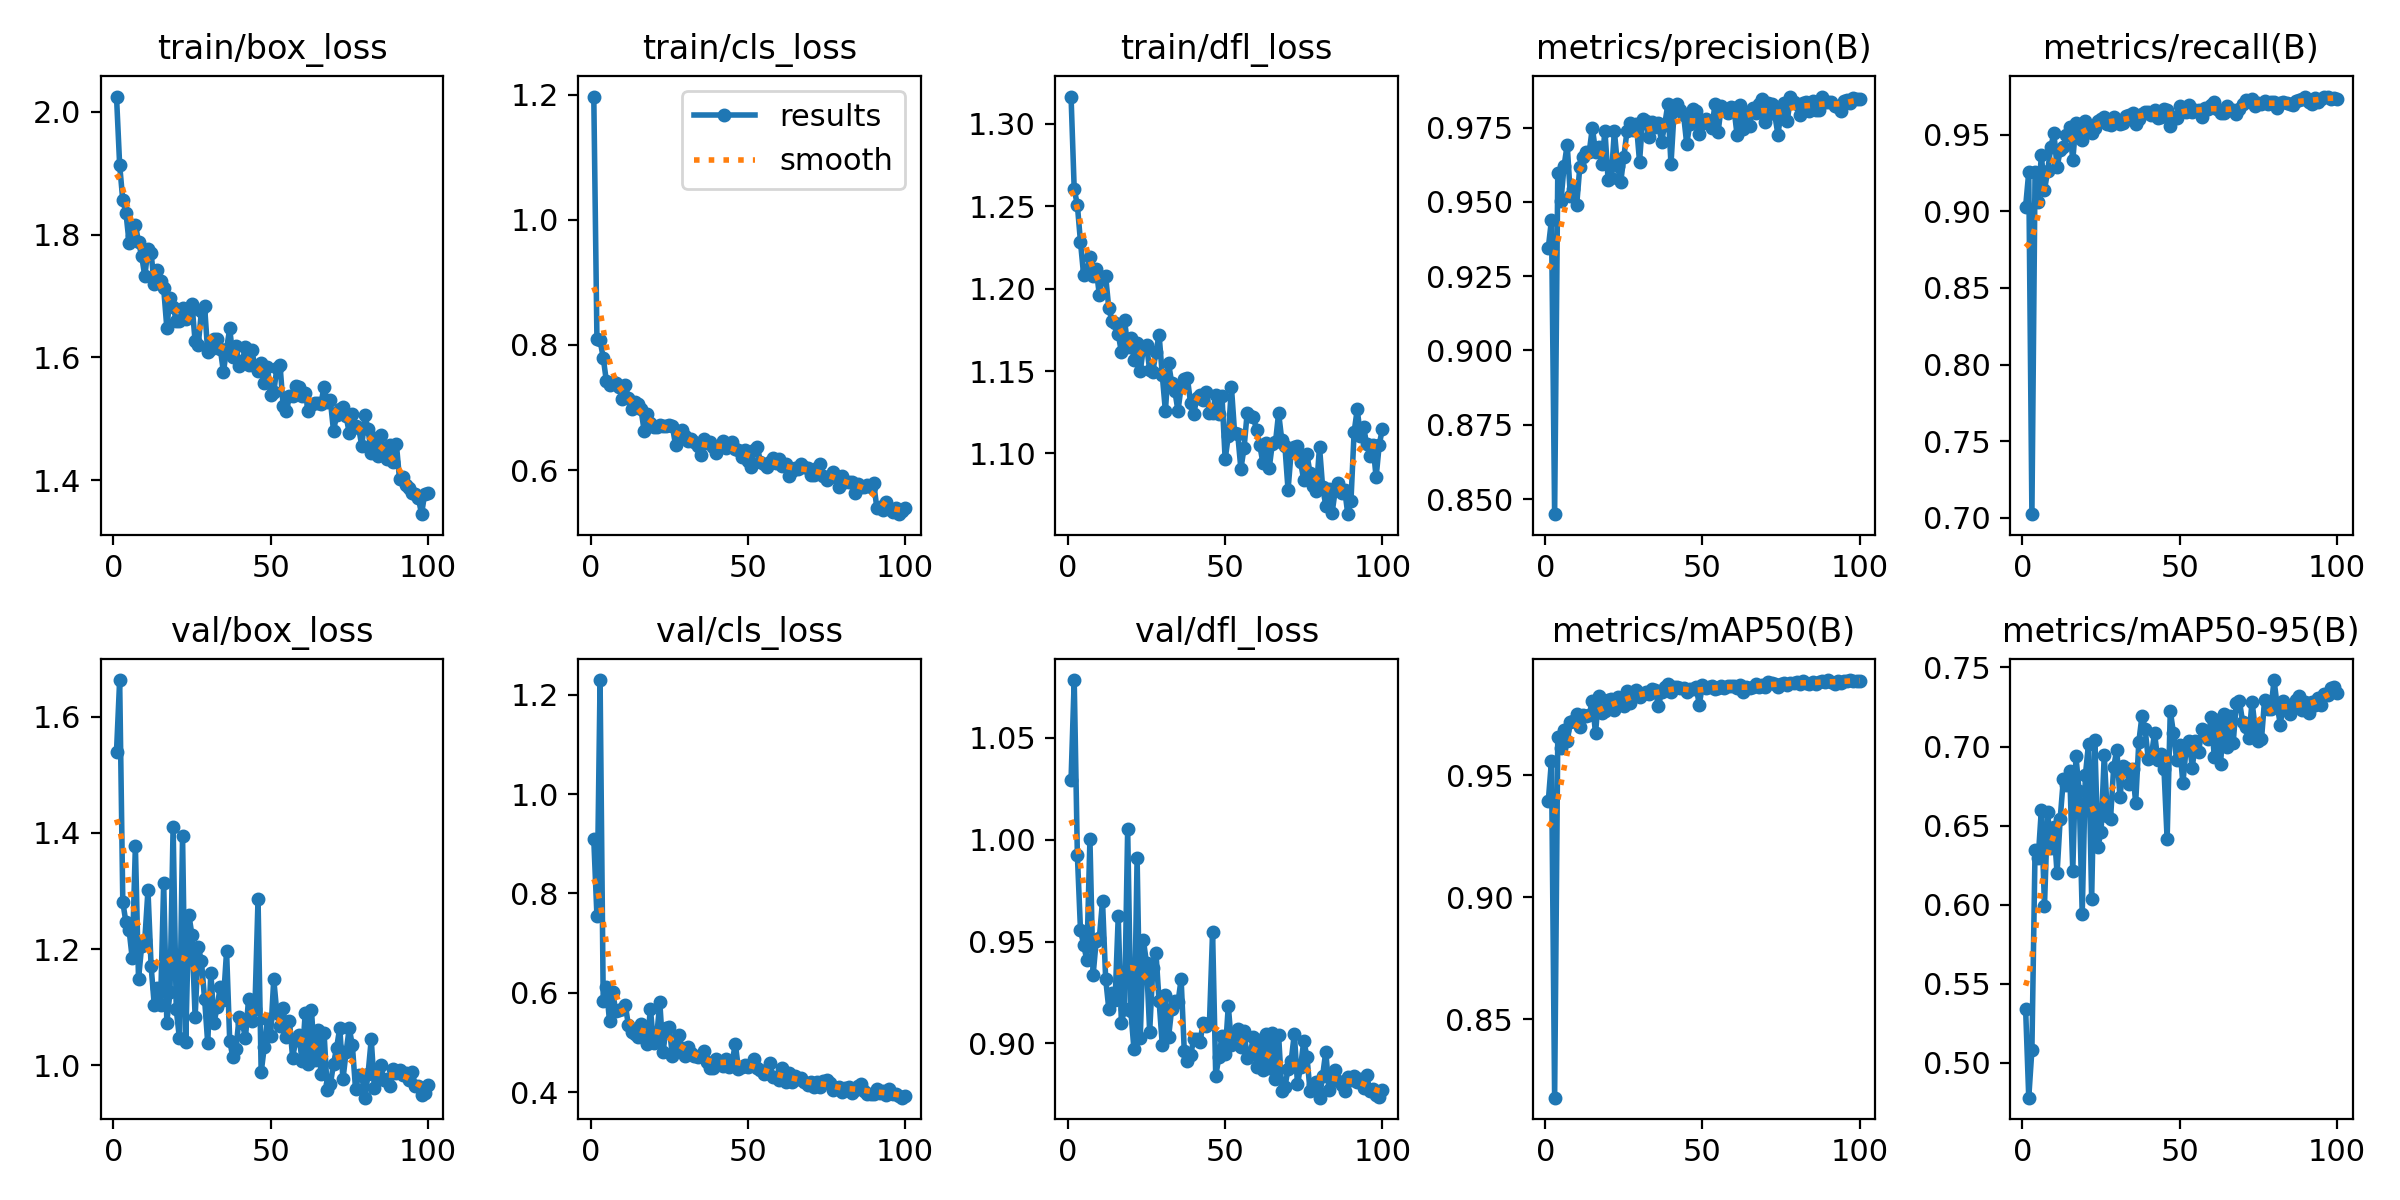

In [ ]:
from IPython.display import Image, display
display(Image("runs/detect/yolov8s_rebar_merged/results.png"))

## Evaluate the Model Performance on Validation sets (Validation Metrics )

In [58]:
# Run validation on the validation split
metrics = model.val(
    data = '/content/rebar-counting-13lzd-26/data.yaml',
    split = 'val'
)

# 3. Extract the numbers via the Metric methods
# Updated to access metrics directly
mAP50       = metrics.box.map50
mAP50_95    = metrics.box.map
precision   = metrics.box.mp
recall      = metrics.box.mr
f1_score    = metrics.box.f1.item()

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1_score:.3f}")
print(f"mAP@0.50:  {mAP50:.3f}")
print(f"mAP@0.50–0.95: {mAP50_95:.3f}")

Ultralytics 8.3.141 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2137.6±433.1 MB/s, size: 129.2 KB)


val: Scanning /content/rebar-counting-13lzd-26/valid/labels.cache... 135 images, 0 backgrounds, 0 corrupt: 100%|██████████| 135/135 [00:00<?, ?it/s]

val: /content/rebar-counting-13lzd-26/valid/images/20CC2D44_jpg.rf.0f147da795826f07078a2815293f7173.jpg: 3 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:19<00:00,  2.15s/it]


                   all        135      17623      0.983      0.971      0.988      0.743
Speed: 3.1ms preprocess, 10.7ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/val16
Precision: 0.983
Recall:    0.971
F1-score:  0.977
mAP@0.50:  0.988
mAP@0.50–0.95: 0.743


In [59]:
# Rebar Counting accuracy
import os
import yaml
from ultralytics import YOLO

# 1. CONFIGURE THESE PATHS
dataset_root = '/content/rebar-counting-13lzd-26'  # <-- change to your dataset folder

# 3. LOAD data.yaml
data_yaml = os.path.join(dataset_root, 'data.yaml')
if not os.path.isfile(data_yaml):
    raise FileNotFoundError(f"Cannot find data.yaml at {data_yaml}")
with open(data_yaml) as f:
    cfg = yaml.safe_load(f)

# 4. RESOLVE VALIDATION IMAGE & LABEL DIRECTORIES
#    e.g. cfg['val'] might be '../valid/images' or 'valid/images'
val_rel = cfg['val'].lstrip('../')     # strip any leading ../
val_dir = os.path.normpath(os.path.join(dataset_root, val_rel))
if not os.path.isdir(val_dir):
    raise FileNotFoundError(f"Validation images directory not found: {val_dir}")

# Label files are assumed in the parallel 'labels' folder
labels_dir = val_dir.replace(os.sep+'images', os.sep+'labels')
if not os.path.isdir(labels_dir):
    raise FileNotFoundError(f"Validation labels directory not found: {labels_dir}")

# 5. LIST VALIDATION IMAGES
val_images = sorted([
    os.path.join(val_dir, fn)
    for fn in os.listdir(val_dir)
    if fn.lower().endswith(('.jpg','jpeg','png'))
])
if not val_images:
    raise FileNotFoundError(f"No images found in {val_dir}")

# 6. RUN INFERENCE & COLLECT pred_counts
results     = model.predict(source=val_images, conf=0.50, iou=0.50, verbose=False)
pred_counts = [len(res.boxes) for res in results]

# 7. READ GROUND-TRUTH COUNTS INTO true_counts
true_counts = []
for img_path in val_images:
    base = os.path.splitext(os.path.basename(img_path))[0]
    lbl  = os.path.join(labels_dir, base + '.txt')
    if not os.path.isfile(lbl):
        raise FileNotFoundError(f"Label file not found for {img_path}: expected {lbl}")
    # each non-empty line in YOLO .txt is one object
    with open(lbl) as f:
        lines = [l for l in f.read().splitlines() if l.strip()]
    true_counts.append(len(lines))

# 8. ENSURE ALIGNMENT
assert len(pred_counts) == len(true_counts), \
       "Mismatch: pred_counts and true_counts lengths differ"

# 9. COMPUTE METRICS
N = len(true_counts)
errors = [abs(p - t) for p,t in zip(pred_counts, true_counts)]
mae    = sum(errors) / N

# Counting Accuracy (COCO-style recall)
correct = [min(p, t) for p,t in zip(pred_counts, true_counts)]
count_acc = sum(correct) / sum(true_counts) * 100

# Exact-Match Accuracy
exact_acc = sum(1 for p,t in zip(pred_counts, true_counts) if p == t) / N * 100

# 10. PRINT RESULTS
print(f"Validation images:            {N}")
print(f"MAE (Mean Absolute Error):     {mae:.3f} rebars/image")
print(f"Counting Accuracy (Recall):    {count_acc:.2f}%")
print(f"Exact-Match Accuracy:          {exact_acc:.2f}%")

Validation images:            135
MAE (Mean Absolute Error):     4.393 rebars/image
Counting Accuracy (Recall):    96.82%
Exact-Match Accuracy:          26.67%


In [60]:
import pandas as pd
from tabulate import tabulate


# 1. DataFrame for Detection Metrics
detection_data = {
    'Metric': [
        'Precision',
        'Recall',
        'F1-score', # Ensure you have an f1_score variable
        'mAP@0.50',
        'mAP@0.50–0.95'
    ],
    'Value': [
        f"{precision:.3f}",
        f"{recall:.3f}",
        f"{f1_score:.3f}", # Using the f1_score variable
        f"{mAP50:.3f}",
        f"{mAP50_95:.3f}"
    ]
}
df_detection = pd.DataFrame(detection_data)

# 2. DataFrame for Counting Metrics
counting_data = {
    'Metric': [
        'Validation Images Processed',
        'Mean Absolute Error (MAE)',
        'Counting Accuracy (COCO-style)',
        'Exact-Match Accuracy'
    ],
    'Value': [
        f"{N}", # Using the N variable
        f"{mae:.3f} rebars/image", # Using the mae variable
        f"{count_acc:.2f}%", # Using the count_acc variable
        f"{exact_acc:.2f}%"  # Using the exact_acc variable
    ]
}
df_counting = pd.DataFrame(counting_data)

# --- Print the tables ---

print("\n--- Object Detection Performance Metrics (Validation Set) ---")
print(tabulate(df_detection, headers='keys', tablefmt='grid', showindex=False))
print("\n") # Add a newline for spacing

print("--- Counting Performance Metrics (Validation Set) ---")
print(tabulate(df_counting, headers='keys', tablefmt='grid', showindex=False))


--- Object Detection Performance Metrics (Validation Set) ---
+---------------+---------+
| Metric        |   Value |
+===============+=========+
| Precision     |   0.983 |
+---------------+---------+
| Recall        |   0.971 |
+---------------+---------+
| F1-score      |   0.977 |
+---------------+---------+
| mAP@0.50      |   0.988 |
+---------------+---------+
| mAP@0.50–0.95 |   0.743 |
+---------------+---------+


--- Counting Performance Metrics (Validation Set) ---
+--------------------------------+--------------------+
| Metric                         | Value              |
+================================+====================+
| Validation Images Processed    | 135                |
+--------------------------------+--------------------+
| Mean Absolute Error (MAE)      | 4.393 rebars/image |
+--------------------------------+--------------------+
| Counting Accuracy (COCO-style) | 96.82%             |
+--------------------------------+--------------------+
| Exact-Match

## Evaluate the Model Performance on Testing sets (Validation Metrics )

In [35]:
# Run validation on the test split
metrics = model.val(
    data = '/content/rebar-counting-13lzd-26/data.yaml',
    split = 'test'
)

# Extract the numbers via the Metric methods
# Updated to access metrics directly
mAP50       = metrics.box.map50
mAP50_95    = metrics.box.map
precision   = metrics.box.mp
recall      = metrics.box.mr
f1_score    = metrics.box.f1.item()

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1_score:.3f}")
print(f"mAP@0.50:  {mAP50:.3f}")
print(f"mAP@0.50–0.95: {mAP50_95:.3f}")

Ultralytics 8.3.141 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2141.0±808.4 MB/s, size: 117.6 KB)


val: Scanning /content/rebar-counting-13lzd-26/test/labels.cache... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


                   all          2        104      0.998       0.99      0.995      0.847
Speed: 0.4ms preprocess, 19.0ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/val14
Precision: 0.998
Recall:    0.990
F1-score:  0.994
mAP@0.50:  0.995
mAP@0.50–0.95: 0.847


In [37]:
import os
import yaml
from ultralytics import YOLO

# 1. CONFIGURE THESE PATHS
dataset_root = '/content/rebar-counting-13lzd-26'       # <-- your dataset folder

# 3. LOAD data.yaml
data_yaml = os.path.join(dataset_root, 'data.yaml')
if not os.path.isfile(data_yaml):
    raise FileNotFoundError(f"Cannot find data.yaml at {data_yaml}")
with open(data_yaml) as f:
    cfg = yaml.safe_load(f)

# 4. RESOLVE TEST IMAGE & LABEL DIRECTORIES
test_rel = cfg['test'].lstrip('../')  # strip any leading ../
test_dir = os.path.normpath(os.path.join(dataset_root, test_rel))
if not os.path.isdir(test_dir):
    raise FileNotFoundError(f"Test images directory not found: {test_dir}")

# Labels are assumed in a parallel 'labels' folder
labels_dir = test_dir.replace(os.sep + 'images', os.sep + 'labels')
if not os.path.isdir(labels_dir):
    raise FileNotFoundError(f"Test labels directory not found: {labels_dir}")

# 5. LIST TEST IMAGES
test_images = sorted([
    os.path.join(test_dir, fn)
    for fn in os.listdir(test_dir)
    if fn.lower().endswith(('.jpg', 'jpeg', 'png'))
])
if not test_images:
    raise FileNotFoundError(f"No images found in {test_dir}")

# 6. RUN INFERENCE & COLLECT pred_counts
results     = model.predict(source=test_images, conf=0.50, iou=0.50, verbose=False)
pred_counts = [len(res.boxes) for res in results]

# 7. READ GROUND-TRUTH COUNTS INTO true_counts
true_counts = []
for img_path in test_images:
    base = os.path.splitext(os.path.basename(img_path))[0]
    lbl  = os.path.join(labels_dir, base + '.txt')
    if not os.path.isfile(lbl):
        raise FileNotFoundError(f"Label file not found for {img_path}: expected {lbl}")
    with open(lbl) as f:
        # count only non-empty lines (one per object)
        lines = [l for l in f.read().splitlines() if l.strip()]
    true_counts.append(len(lines))

# 8. ENSURE ALIGNMENT
assert len(pred_counts) == len(true_counts), \
       "Mismatch: pred_counts and true_counts lengths differ"

# 9. COMPUTE METRICS
N = len(true_counts)
errors = [abs(p - t) for p,t in zip(pred_counts, true_counts)]
mae    = sum(errors) / N

# Counting Accuracy (COCO-style recall)
correct   = [min(p, t) for p,t in zip(pred_counts, true_counts)]
count_acc = sum(correct) / sum(true_counts) * 100

# Exact-Match Accuracy
exact_acc = sum(1 for p,t in zip(pred_counts, true_counts) if p == t) / N * 100

# 10. PRINT RESULTS
print(f"Test images:                  {N}")
print(f"MAE (Mean Absolute Error):     {mae:.3f} rebars/image")
print(f"Counting Accuracy (Recall):    {count_acc:.2f}%")
print(f"Exact-Match Accuracy:          {exact_acc:.2f}%")


Test images:                  2
MAE (Mean Absolute Error):     0.000 rebars/image
Counting Accuracy (Recall):    100.00%
Exact-Match Accuracy:          100.00%


## Run inference and draw bounding box on testing set


image 1/2 /content/rebar-counting-13lzd-26/test/images/881B376F_jpg.rf.7fa6c95676f13ac29fea00d71c4b1a97.jpg: 640x640 45 rebars, 16.2ms
image 2/2 /content/rebar-counting-13lzd-26/test/images/company_rebar_58_jpg.rf.8e70da28509f580c031558106ab7af15.jpg: 640x640 59 rebars, 16.2ms
Speed: 3.8ms preprocess, 16.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


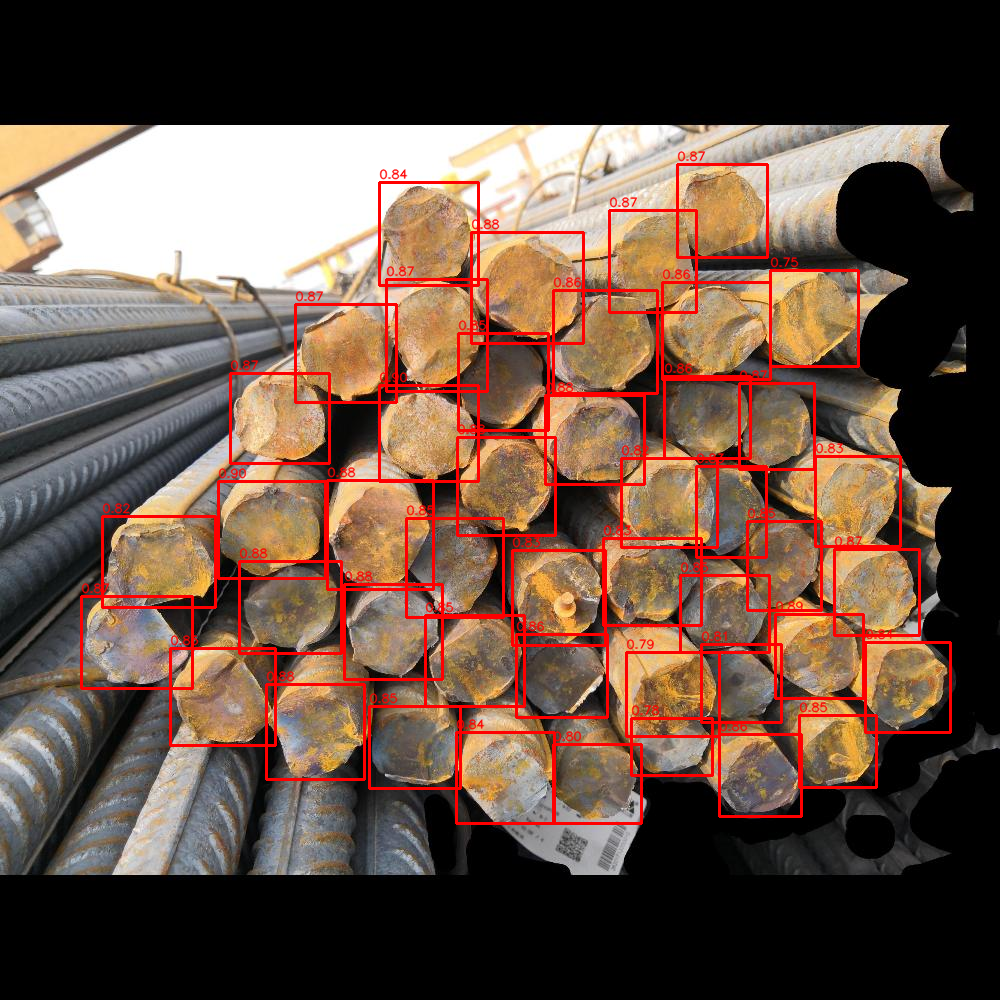

Ground-Truth count: 45
Predicted    count: 45


In [ ]:
from ultralytics import YOLO
import cv2, os
from IPython.display import Image, display

# 1) load your best model
best_model = YOLO('runs/detect/yolov8s_rebar_merged/weights/best.pt')

# 2) run inference on the entire test folder, but don't save with the default plot()
results = best_model.predict(
    source='/content/rebar-counting-13lzd-26/test/images',
    conf=0.50,
    iou=0.50,
    save=False  # we’ll draw ourselves
)

# 3) grab the first result & its source file path
# --- The change is here ---
res = results[0]
img_path = res.path # Access the path from the Results object
# --- End of change ---

# 4) load it with OpenCV
img = cv2.imread(img_path)

# 5) draw each box + tiny confidence label in red
for box, conf in zip(res.boxes.xyxy, res.boxes.conf):
    x1, y1, x2, y2 = map(int, box.tolist())
    # red bounding box
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), thickness=2)
    # small red confidence
    cv2.putText(
        img,
        f"{conf:.2f}",
        (x1, y1 - 4),
        cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.4,
        color=(0, 0, 255),
        thickness=1,
        lineType=cv2.LINE_AA,
    )

# 6) save & display
out_path = 'annotated.png'
cv2.imwrite(out_path, img)
display(Image(out_path))

# 7) count ground-truth vs. predictions
img_name = os.path.basename(img_path)
label_file = img_name.rsplit('.', 1)[0] + '.txt'
gt_file = os.path.join(
    '/content/rebar-counting-13lzd-26/test/labels',
    label_file
)
with open(gt_file) as f:
    gt_count = sum(1 for l in f if l.strip())
pred_count = len(res.boxes)

print(f"Ground-Truth count: {gt_count}")
print(f"Predicted    count: {pred_count}")

## Inference - Detecting Rebars in New Images

In [ ]:
!mkdir inference/


image 1/1 /content/inference/13.jpg: 640x640 263 rebars, 42.4ms
Speed: 1.9ms preprocess, 42.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Detected 263 rebars in 13.jpg


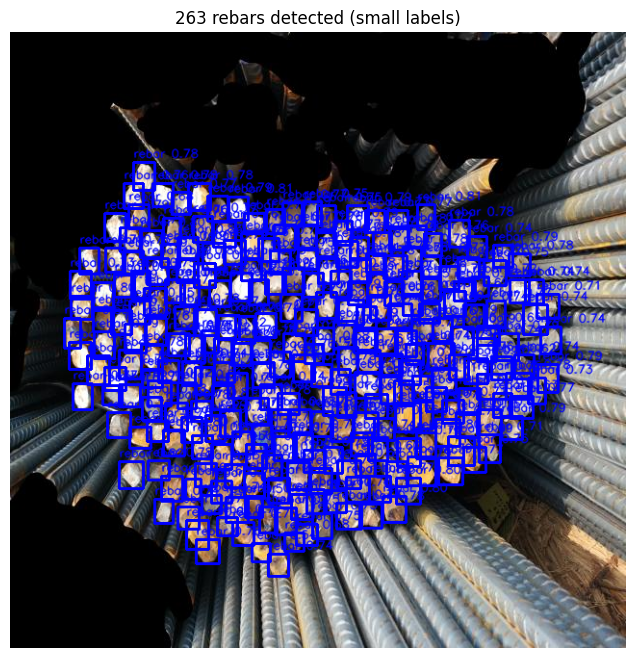

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Load your trained model
model = YOLO('runs/detect/yolov8s_rebar_merged/weights/best.pt')

# 2. Path to your new image
new_image_path = '/content/inference/13.jpg'

# 3. Run inference (no saving)
results = model.predict(
    source=new_image_path,
    # augment=True,
    conf=0.50,
    iou=0.50,
    save=False
)

# 4. Get the first (and only) result
res = results[0]

# 5. Count detections
count = len(res.boxes)
print(f"Detected {count} rebars in {os.path.basename(new_image_path)}")

# 6. Load the original image with OpenCV (BGR)
img = cv2.imread(new_image_path)

# 7. Draw each box + label with a small font
for box in res.boxes:
    # extract coordinates & confidence
    x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
    conf = float(box.conf[0])
    label = f"rebar {conf:.2f}"
    # draw box
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    # draw smaller label above the box
    cv2.putText(
        img, label, (x1, y1 - 5),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.4,      # <-- small font
        color=(255, 0, 0),
        thickness=1,
        lineType=cv2.LINE_AA
    )

# 8. Convert BGR → RGB and display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"{count} rebars detected (small labels)")
plt.show()


## Save the Model and Next Steps for Deployment

In [ ]:
from google.colab import drive
import shutil
import os

# 1. Mount Google Drive (follow the link & authenticate)
drive.mount('/content/drive')

# 2. Prepare your destination folder
dst_dir = '/content/drive/MyDrive/models/rebar_yolov8s/merge_version/augmentation with 100 epochs'
os.makedirs(dst_dir, exist_ok=True)

# 3. Paths to your two “best.pt” checkpoints
src = 'runs/detect/yolov8s_rebar_merged/weights/best.pt'

# 4. Destination paths
dst = os.path.join(dst_dir, 'rebar_yolov8s_rebar_merged_best.pt')

# 5. Copy them over
shutil.copy(src, dst)
print(f"Model saved to {dst}")

Mounted at /content/drive
Model saved to /content/drive/MyDrive/models/rebar_yolov8s/merge_version/augmentation with 100 epcochs/rebar_yolov8s_rebar_merged_best.pt


## Convert the model to Torchscript

In [ ]:
model.export(format='torchscript', imgsz=640, optimize=True)

Ultralytics 8.3.115 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/yolov8s_rebar_merged/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (21.5 MB)

TorchScript: starting export with torch 2.6.0+cu124...
TorchScript: optimizing for mobile...
TorchScript: export success ✅ 4.1s, saved as 'runs/detect/yolov8s_rebar_merged/weights/best.torchscript' (42.6 MB)

Export complete (6.3s)
Results saved to /content/runs/detect/yolov8s_rebar_merged/weights
Predict:         yolo predict task=detect model=runs/detect/yolov8s_rebar_merged/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs/detect/yolov8s_rebar_merged/weights/best.torchscript imgsz=640 data=/content/rebar-counting-13lzd-26/data.yaml  
Visualize:       https://netron.app


'runs/detect/yolov8s_rebar_merged/weights/best.torchscript'